In [11]:
import pandas as pd
import json
import numpy as np

import joblib

pd.set_option('display.max_colwidth',  None)

with open('result.json') as f:
    data = json.load(f)

df = pd.DataFrame(data)

df.fillna(0, inplace=True)
df = df.apply(lambda series: pd.to_numeric(series, errors='coerce'))
df = df.dropna()
df.head()

,Epidian 6D,Araldite GY260,Araldite GY250CH,CHS-520 (*CHS-530),CHS-525,CHS-590,Epidian 5,Epidian 6,Epilox AF 18-50,AH-24/Grilonit epoxide 8,...,trisDMP,DCH-99,MXDA,Ethacure 100,nonilfenol,etanol,AHEW,Fazékidő (min),Szakítószilárdság [MPa],Szakadási nyúlás [%]
0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,24.400000,46.0,82.57,5.58
1,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,27.685325,53.0,41.72,3.35
2,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,31.228669,34.0,56.60,4.76
3,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,35.812133,28.0,61.23,5.59
4,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,27.685325,61.0,41.13,3.67


In [2]:
del df["EEW"]
del df["nonilfenol"]
del df["etanol"]
del df["AHEW"]
df.head()

,Epidian 6D,Araldite GY260,Araldite GY250CH,CHS-520 (*CHS-530),CHS-525,CHS-590,Epidian 5,Epidian 6,Epilox AF 18-50,AH-24/Grilonit epoxide 8,...,TEA/,Dytek A-MPMD/APU-2**,APU-4,trisDMP,DCH-99,MXDA,Ethacure 100,Fazékidő (min),Szakítószilárdság [MPa],Szakadási nyúlás [%]
0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0,82.57,5.58
1,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,41.72,3.35
2,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,56.60,4.76
3,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,61.23,5.59
4,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61.0,41.13,3.67


In [218]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter 

class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, z_dim, out_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, out_dim),
            nn.Tanh(), 
        )

    def forward(self, x):
        return self.gen(x)

In [55]:
df.shape

(361, 33)

In [296]:
from sklearn.preprocessing import StandardScaler

device = "cuda" if torch.cuda.is_available() else "cpu"
lr_disc = 3e-5
lr_gen = 3e-4
z_dim = 64

image_dim = 3
batch_size = 32
num_epochs = 500

disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)


dataset = torch.FloatTensor(df.iloc[:, -3:].values)
ss = StandardScaler().fit(dataset)
dataset = ss.transform(dataset)

loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
opt_disc = optim.Adam(disc.parameters(), lr=lr_gen)
opt_gen = optim.Adam(gen.parameters(), lr=lr_disc)
criterion = nn.MSELoss()
step = 0


for epoch in range(num_epochs):
    for batch_idx, real in enumerate(loader):
        # real = real.view(-1, image).to(device)
        real = torch.tensor(df.iloc[:, -3:].values, dtype=torch.float).to(device)
        batch_size = real.shape[0]

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise).detach().cpu()
        fake = ss.inverse_transform(fake)
        fake = torch.tensor(fake, dtype=torch.float).to(device)  # convert to the same dtype and device as `real`

        disc_real = disc(real)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        # where the second option of maximizing doesn't suffer from
        # saturating gradients
        for _ in range(5):
            output = disc(fake).view(-1)
            lossG = criterion(output, torch.ones_like(output))
            gen.zero_grad()
            lossG.backward()
            opt_gen.step()

        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                      Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )
            step += 1

Epoch [0/500] Batch 0/12                       Loss D: 0.2593, loss G: 0.5483
Epoch [1/500] Batch 0/12                       Loss D: 0.2548, loss G: 0.5805
Epoch [2/500] Batch 0/12                       Loss D: 0.2475, loss G: 0.6269
Epoch [3/500] Batch 0/12                       Loss D: 0.2451, loss G: 0.6292
Epoch [4/500] Batch 0/12                       Loss D: 0.2414, loss G: 0.6029
Epoch [5/500] Batch 0/12                       Loss D: 0.2217, loss G: 0.5609
Epoch [6/500] Batch 0/12                       Loss D: 0.2080, loss G: 0.5402
Epoch [7/500] Batch 0/12                       Loss D: 0.1876, loss G: 0.4266
Epoch [8/500] Batch 0/12                       Loss D: 0.1780, loss G: 0.4152
Epoch [9/500] Batch 0/12                       Loss D: 0.1721, loss G: 0.4189
Epoch [10/500] Batch 0/12                       Loss D: 0.1643, loss G: 0.4560
Epoch [11/500] Batch 0/12                       Loss D: 0.1593, loss G: 0.4559
Epoch [12/500] Batch 0/12                       Loss D: 0.1528

In [360]:
noise = torch.randn(5, 64).to(device)
fake = gen(noise).detach().cpu()
fake = ss.inverse_transform(fake)
fake

array([[30.58759462, 64.86273205,  1.47834056],
       [34.29489898, 68.90811418,  5.22743467],
       [34.25919658, 57.92951026,  5.58895587],
       [34.724756  , 69.47669477,  4.13827668],
       [33.21966022, 62.88449827,  4.50043108]])

In [361]:
import pickle

with open('gen_scaler.pkl', 'wb') as f:
    pickle.dump(ss, f)
    
torch.save(gen.state_dict(), "gen__0_68.pth")


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter 
import pickle

class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, z_dim, out_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, out_dim),
            nn.Tanh(), 
        )

    def forward(self, x):
        return self.gen(x)
    
z_dim = 64
input_number = 3
device = "cuda" if torch.cuda.is_available() else "cpu"

loaded_gen = Generator(z_dim, input_number).to(device)
loaded_gen.load_state_dict(torch.load("gen__0_68.pth"))


with open('gen_scaler.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)


noise = torch.randn(300, 64).to(device)
fake = loaded_gen(noise).detach().cpu()
fake = loaded_scaler.inverse_transform(fake)
fake

array([[36.87521624, 57.19142367,  2.24027629],
       [34.06742291, 66.24055468,  3.06285615],
       [33.69929181, 62.60211285,  1.68742737],
       [28.88397748, 65.48657599,  2.36158272],
       [30.75421409, 66.65488486,  4.40208841],
       [38.24149681, 59.90368674,  3.51346853],
       [32.50836246, 61.50762896,  4.45735236],
       [34.69170936, 70.27481306,  4.29701374],
       [30.99318464, 65.95392094,  3.26053354],
       [25.54435261, 67.78126502,  3.67455825],
       [31.58011432, 63.45661761,  6.71011017],
       [32.81009892, 62.08443403,  5.48287263],
       [37.33386441, 64.9236308 ,  5.37950785],
       [34.55375493, 62.99944767,  4.642647  ],
       [35.88498574, 68.47987701,  3.27444615],
       [37.98607781, 59.74706661,  6.51639335],
       [27.37790238, 63.17114371,  3.84763531],
       [33.95930321, 67.40332231,  3.61153137],
       [34.17288211, 64.34460138,  4.63270269],
       [31.45798118, 63.4953432 ,  2.77852933],
       [41.0091209 , 63.69152604,  4.550

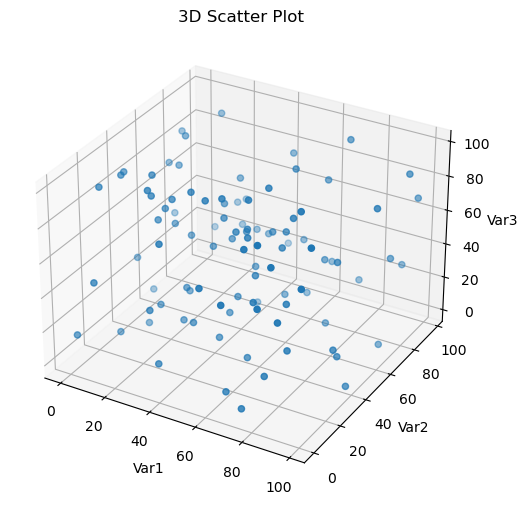

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Creating a random dataframe for illustration
np.random.seed(0)  # for reproducible random results

df = pd.DataFrame({
   'var1': np.random.randint(0, 100, 100),
   'var2': np.random.randint(0, 100, 100),
   'var3': np.random.randint(0, 100, 100),
   'output': np.random.randint(0, 100, 100)
})

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
ax.scatter(df.iloc[:, -3], df.iloc[:, -2], df.iloc[:, -1], cmap='viridis')

ax.set_xlabel('Var1')
ax.set_ylabel('Var2')
ax.set_zlabel('Var3')
plt.title('3D Scatter Plot')

plt.show()

# noise = torch.randn(5, 64).to(device)
# synthetic_data = loaded_gen(noise)
# synthetic_data = synthetic_data.cpu().detach().numpy()
# visualize_data_2d(df.iloc[:, :-3], synthetic_data)

In [8]:
noise = torch.randn(361, 64).to(device)
fake = loaded_gen(noise).detach().cpu()
fake = loaded_scaler.inverse_transform(fake)

fake_rounded = [[round(elem, 2) for elem in inner_list] for inner_list in fake]

fake_df = pd.DataFrame(fake_rounded, columns = (['Fazékidő (min)', 'Szakítószilárdság [MPa]', 'Szakadási nyúlás [%]']))


In [9]:
fake_df.shape

(361, 3)

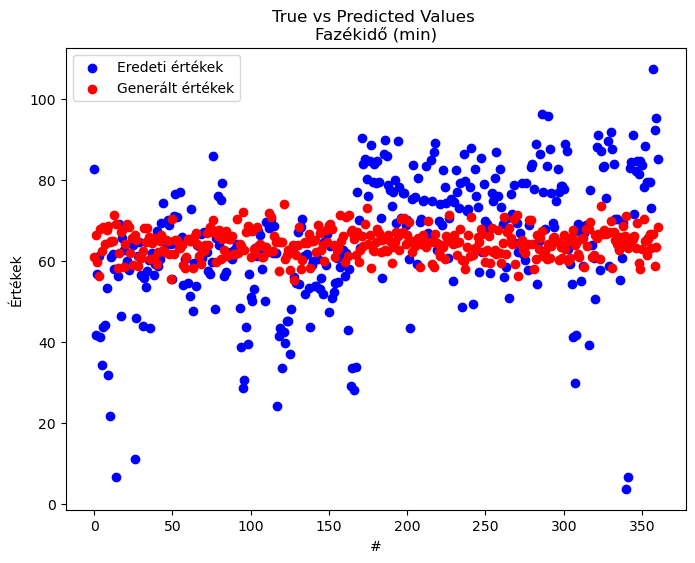

In [12]:
import matplotlib.pyplot as plt

# Assuming y_true are your true output values and y_pred are your predicted output values
y_true = df.iloc[:, -3:]
y_pred = fake_df

plt.figure(figsize=(8, 6))

# Plot the actual values
plt.scatter(range(df.shape[0]), y_true.iloc[:, 1], color='blue', label='Eredeti értékek')

# Plot the predicted values
plt.scatter(range(fake_df.shape[0]), y_pred.iloc[:, 1], color='red', label='Generált értékek')

plt.title('True vs Predicted Values \nFazékidő (min)')
plt.xlabel('#')
plt.ylabel('Értékek')
plt.legend()

plt.show()


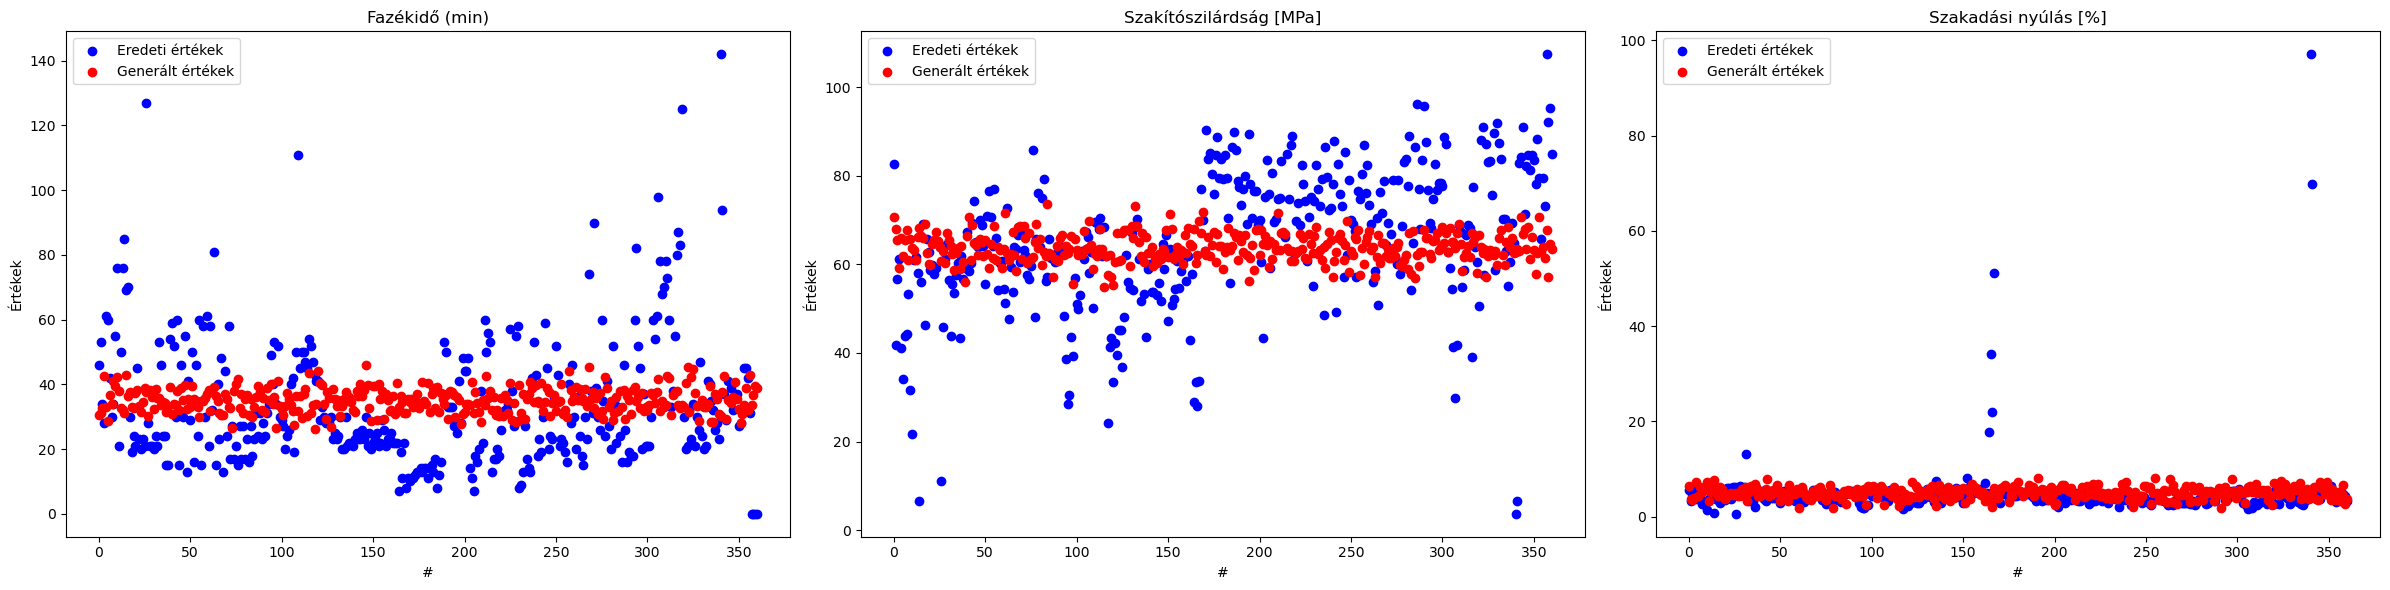

In [13]:
import matplotlib.pyplot as plt

noise = torch.randn(361, 64).to(device)
fake = loaded_gen(noise).detach().cpu()
fake = loaded_scaler.inverse_transform(fake)

fake_rounded = [[round(elem, 2) for elem in inner_list] for inner_list in fake]

fake_df = pd.DataFrame(fake_rounded, columns = (['Fazékidő (min)', 'Szakítószilárdság [MPa]', 'Szakadási nyúlás [%]']))

# Assuming y_true are your true output values and y_pred are your predicted output values
y_true = df.iloc[:, -3:]
y_pred = fake_df

fig, axs = plt.subplots(1, 3, figsize=(24, 6))  # 1 row, 3 columns

# Plot the actual values and the predicted values for the first feature
axs[0].scatter(range(df.shape[0]), y_true.iloc[:, 0], color='blue', label='Eredeti értékek')
axs[0].scatter(range(fake_df.shape[0]), y_pred.iloc[:, 0], color='red', label='Generált értékek')
axs[0].set_title('Fazékidő (min)')
axs[0].set_xlabel('#')
axs[0].set_ylabel('Értékek')
axs[0].legend()

# Repeat for the second feature
axs[1].scatter(range(df.shape[0]), y_true.iloc[:, 1], color='blue', label='Eredeti értékek')
axs[1].scatter(range(fake_df.shape[0]), y_pred.iloc[:, 1], color='red', label='Generált értékek')
axs[1].set_title('Szakítószilárdság [MPa]')
axs[1].set_xlabel('#')
axs[1].set_ylabel('Értékek')
axs[1].legend()

# Repeat for the third feature
axs[2].scatter(range(df.shape[0]), y_true.iloc[:, 2], color='blue', label='Eredeti értékek')
axs[2].scatter(range(fake_df.shape[0]), y_pred.iloc[:, 2], color='red', label='Generált értékek')
axs[2].set_title('Szakadási nyúlás [%]')
axs[2].set_xlabel('#')
axs[2].set_ylabel('Értékek')
axs[2].legend()

plt.tight_layout()
plt.show()


# GAN evaluation

In [22]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np

fake_values = fake_df.values
real_values = df.iloc[:, -3:].values

assert fake_values.shape == real_values.shape

# Calculate the mean squared error for each sample
mse_values = [mean_squared_error(real_sample, gan_sample) for real_sample, gan_sample in zip(real_values, fake_values)]
mse_values_per_column = [mean_squared_error(real_values[:, i], fake_values[:, i]) for i in range(fake_values.shape[1])]
mae_values_per_column = [mean_absolute_error(real_values[:, i], fake_values[:, i]) for i in range(fake_values.shape[1])]


# Calculate the mean MSE over all samples
mean_mse = np.mean(mse_values)

print(f"Mean MSE: {mean_mse}")
print(f"MSE per column: {mse_values_per_column}")
print(f"MAE per column: {mae_values_per_column}")


Mean MSE: 239.7088949215143
MSE per column: [413.83144875346255, 256.4135645429363, 48.881671468144035]
MAE per column: [15.412022160664819, 12.287036011080332, 2.2373407202216065]


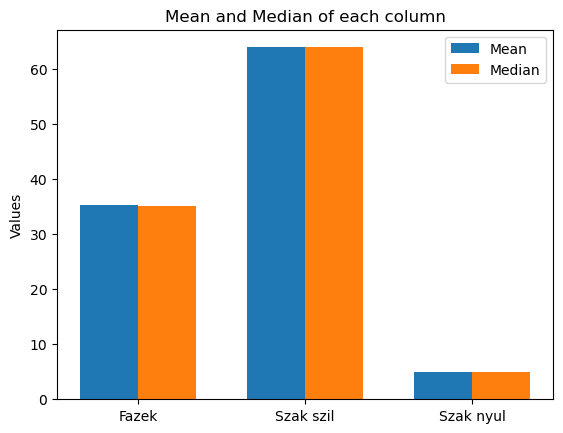

In [392]:
import pandas
import numpy
import matplotlib.pyplot as plt

noise = torch.randn(300, 64).to(device)
fake = loaded_gen(noise).detach().cpu()
fake = loaded_scaler.inverse_transform(fake)

df = pandas.DataFrame(fake, columns = (['Fazek', 'Szak szil', 'Szak nyul']))
mean_values = df.mean()
median_values = df.median()

# Define a range for X axis
x = np.arange(len(df.iloc[:, -3:].columns))

# Set width of a bar in bar plot
width = 0.35

# Visualize the mean and median
fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, mean_values, width, label='Mean')
rects2 = ax.bar(x + width/2, median_values, width, label='Median')

# Add some text for labels, title and custom x-axis tick labels
ax.set_ylabel('Values')
ax.set_title('Mean and Median of each column')
ax.set_xticks(x)
ax.set_xticklabels(['Fazek', 'Szak szil', 'Szak nyul'])
ax.legend()

# Show the plot
plt.show()

In [378]:
df.head()

,Fazek,Szak szil,Szak nyul
0,41.021812,63.058546,5.066369
1,34.399100,63.140753,4.000892
2,33.421052,63.471824,4.083830
3,32.233656,64.164255,4.786693
4,35.234357,62.353446,6.416062


In [426]:
def predict_with_all_models(models, scalers, input_data):
    # Initialize an empty DataFrame to store the predictions
    predictions_df = pd.DataFrame()

    # Iterate over the models
    for column_name in models.keys():
        # Get the corresponding model and scaler
        model = models[column_name]
        scaler = scalers[column_name]

        # Scale the input data
        input_data_scaled = scaler.transform(input_data)

        # Make predictions with the model
        predictions = model.predict(input_data_scaled)

        # Add the predictions to the DataFrame
        predictions_df[column_name] = predictions

    return predictions_df

def generate_input_sample(gen, scaler):
    noise = torch.randn(1, 64).to(device)
    fake = gen(noise).detach().cpu()
    fake = scaler.inverse_transform(fake)
    fake_rounded =[[ round(elem, 2) for elem in fake[0] ]]

    fake_df = pandas.DataFrame(fake_rounded, columns = (['Fazékidő (min)', 'Szakítószilárdság [MPa]', 'Szakadási nyúlás [%]']))


    return fake_df


def generate_synthetic_data(models, scalers, num_samples):
    synthetic_data = pd.DataFrame()
    
    for i in range(num_samples):
        # Generate a new input sample. This depends on your specific problem
        input_data = generate_input_sample(loaded_gen, loaded_scaler)
        
        # Predict the output using the models
        output_data = predict_with_all_models(models, scalers, input_data)
        
        # Combine the input and output data into a single DataFrame
        sample_data = pd.concat([output_data, input_data], axis=1)
        
        # Add the sample to the synthetic data
        synthetic_data = synthetic_data.append(sample_data)
    
    return synthetic_data

In [394]:
import pickle

# Load the models
with open('class_reg_models.pkl', 'rb') as f:
    loaded_models = pickle.load(f)

# Load the scalers
with open('class_reg_scalers.pkl', 'rb') as f:
    loaded_scalers = pickle.load(f)

# Load the results_df
loaded_results_df = pd.read_pickle('class_reg_results_df.pkl')

In [417]:
synthetic_data = generate_synthetic_data(loaded_models, loaded_scalers, num_samples=1)
synthetic_data


[[35.36, 59.63, 6.2]]


C:\Users\user\AppData\Local\Temp\ipykernel_20396\687400324.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  synthetic_data = synthetic_data.append(sample_data)


,Epidian 6D,Araldite GY260,Araldite GY250CH,CHS-520 (*CHS-530),CHS-525,CHS-590,Epidian 5,Epidian 6,Epilox AF 18-50,AH-24/Grilonit epoxide 8,...,trisDMP,DCH-99,MXDA,Ethacure 100,nonilfenol,etanol,AHEW,Fazékidő (min),Szakítószilárdság [MPa],Szakadási nyúlás [%]
0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,66.742403,35.36,59.63,6.2


In [420]:
df.shape

(361, 37)

In [421]:
augmented_data = pd.concat([df, synthetic_data])
augmented_data


,Epidian 6D,Araldite GY260,Araldite GY250CH,CHS-520 (*CHS-530),CHS-525,CHS-590,Epidian 5,Epidian 6,Epilox AF 18-50,AH-24/Grilonit epoxide 8,...,trisDMP,DCH-99,MXDA,Ethacure 100,nonilfenol,etanol,AHEW,Fazékidő (min),Szakítószilárdság [MPa],Szakadási nyúlás [%]
0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,24.400000,46.00,82.57,5.58
1,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,27.685325,53.00,41.72,3.35
2,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,31.228669,34.00,56.60,4.76
3,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,35.812133,28.00,61.23,5.59
4,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,27.685325,61.00,41.13,3.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,30.0,0.0,0,0,60.134188,0.00,107.38,4.81
366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,30.0,0.0,0,0,60.134188,0.00,92.19,4.71
367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,30.0,0.0,0,0,60.134188,0.00,95.27,4.24
368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,30.0,0.0,0,0,60.134188,0.00,84.99,3.30


# Reg test without augmneted data

In [422]:
df.columns[13]

'IPOX ER 1010'

In [430]:
import pandas as pd
import json
import numpy as np

import joblib

pd.set_option('display.max_colwidth',  None)

with open('result.json') as f:
    data = json.load(f)

df = pd.DataFrame(data)

df.fillna(0, inplace=True)
df = df.apply(lambda series: pd.to_numeric(series, errors='coerce'))
df = df.dropna()
df.head()

,Epidian 6D,Araldite GY260,Araldite GY250CH,CHS-520 (*CHS-530),CHS-525,CHS-590,Epidian 5,Epidian 6,Epilox AF 18-50,AH-24/Grilonit epoxide 8,...,trisDMP,DCH-99,MXDA,Ethacure 100,nonilfenol,etanol,AHEW,Fazékidő (min),Szakítószilárdság [MPa],Szakadási nyúlás [%]
0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,24.400000,46.0,82.57,5.58
1,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,27.685325,53.0,41.72,3.35
2,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,31.228669,34.0,56.60,4.76
3,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,35.812133,28.0,61.23,5.59
4,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,27.685325,61.0,41.13,3.67


In [424]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd

X = df.iloc[:, -3:]

# a list to store results
results = []

# dictionaries to store models and scalers
models = {}
scalers = {}

# loop over the column indices
# get the column name
col_name = df.columns[13]

# create the target vector
y = df.iloc[:, 13]

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# prepare and store the standard scaler
ss = StandardScaler().fit(X_train)
scalers[col_name] = ss

# transform the data
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)


# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = RandomForestRegressor(), param_grid = param_grid, 
                        cv = 5, scoring='neg_mean_squared_error', n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Retrieve the best model
best_rf_model = grid_search.best_estimator_
# Print the best parameters
best_params = grid_search.best_params_
print(f'Best parameters for [{col_name}]:', best_params)


# Create a RandomForestRegressor object
# rf_model = RandomForestRegressor()
rf_model = best_rf_model

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = rf_model.predict(X_train)

# Evaluate the model on the training set
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

# Make predictions on the test set
y_test_pred = rf_model.predict(X_test)

# Evaluate the model on the test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Store results
results.append({
    'column': col_name,
    'train_rmse': train_rmse,
    'train_r2': train_r2,
    'train_mae': train_mae,
    'test_rmse': test_rmse,
    'test_r2': test_r2,
    'test_mae': test_mae,
    'model': rf_model,
    'model_params': best_params
})

# Store model
models[col_name] = rf_model

# create a DataFrame from the results
results_df = pd.DataFrame(results)

print(results_df)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters for [IPOX ER 1010]: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
         column  train_rmse  train_r2  train_mae  test_rmse   test_r2  \
0  IPOX ER 1010   14.650032  0.866757  10.334941  26.418613  0.546082   

    test_mae  \
0  17.663179   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

# With augmented data

In [427]:
synthetic_data = generate_synthetic_data(loaded_models, loaded_scalers, num_samples=200)
augmented_data = pd.concat([df, synthetic_data])


C:\Users\user\AppData\Local\Temp\ipykernel_20396\236671939.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  synthetic_data = synthetic_data.append(sample_data)
C:\Users\user\AppData\Local\Temp\ipykernel_20396\236671939.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  synthetic_data = synthetic_data.append(sample_data)
C:\Users\user\AppData\Local\Temp\ipykernel_20396\236671939.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  synthetic_data = synthetic_data.append(sample_data)
C:\Users\user\AppData\Local\Temp\ipykernel_20396\236671939.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  synthetic_data = synthetic_data.append(s

In [428]:
augmented_data

,Epidian 6D,Araldite GY260,Araldite GY250CH,CHS-520 (*CHS-530),CHS-525,CHS-590,Epidian 5,Epidian 6,Epilox AF 18-50,AH-24/Grilonit epoxide 8,...,trisDMP,DCH-99,MXDA,Ethacure 100,nonilfenol,etanol,AHEW,Fazékidő (min),Szakítószilárdság [MPa],Szakadási nyúlás [%]
0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,24.400000,46.00,82.57,5.58
1,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,27.685325,53.00,41.72,3.35
2,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,31.228669,34.00,56.60,4.76
3,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,35.812133,28.00,61.23,5.59
4,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,27.685325,61.00,41.13,3.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,54.582502,27.12,66.99,4.89
0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,48.020350,36.46,66.42,5.49
0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,80.687436,42.35,64.69,6.29
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,45.237649,35.94,68.38,4.63


In [429]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd

df = augmented_data

X = df.iloc[:, -3:]

# a list to store results
results = []

# dictionaries to store models and scalers
models = {}
scalers = {}

# loop over the column indices
# get the column name
col_name = df.columns[13]

# create the target vector
y = df.iloc[:, 13]

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# prepare and store the standard scaler
ss = StandardScaler().fit(X_train)
scalers[col_name] = ss

# transform the data
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)


# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = RandomForestRegressor(), param_grid = param_grid, 
                        cv = 5, scoring='neg_mean_squared_error', n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Retrieve the best model
best_rf_model = grid_search.best_estimator_
# Print the best parameters
best_params = grid_search.best_params_
print(f'Best parameters for [{col_name}]:', best_params)


# Create a RandomForestRegressor object
# rf_model = RandomForestRegressor()
rf_model = best_rf_model

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = rf_model.predict(X_train)

# Evaluate the model on the training set
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

# Make predictions on the test set
y_test_pred = rf_model.predict(X_test)

# Evaluate the model on the test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Store results
results.append({
    'column': col_name,
    'train_rmse': train_rmse,
    'train_r2': train_r2,
    'train_mae': train_mae,
    'test_rmse': test_rmse,
    'test_r2': test_r2,
    'test_mae': test_mae,
    'model': rf_model,
    'model_params': best_params
})

# Store model
models[col_name] = rf_model

# create a DataFrame from the results
results_df = pd.DataFrame(results)

print(results_df)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters for [IPOX ER 1010]: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
         column  train_rmse  train_r2  train_mae  test_rmse   test_r2  \
0  IPOX ER 1010    7.993927   0.95709    4.81134  23.445452  0.565748   

    test_mae  \
0  14.038514   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [463]:
test_model = models['IPOX ER 1010']
test_scaler = scalers['IPOX ER 1010']
test_pred = rf_model.predict(test_scaler.transform([[8, 77, 3.64]]))
test_pred


c:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([48.])

# Synthetic data

In [ ]:
synthetic_data = generate_synthetic_data(loaded_models, loaded_scalers, num_samples=1000)

In [431]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd


X = synthetic_data.iloc[:, -3:]

# a list to store results
results = []

# dictionaries to store models and scalers
models = {}
scalers = {}

# loop over the column indices
# get the column name
col_name = synthetic_data.columns[13]

# create the target vector
y = synthetic_data.iloc[:, 13]

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.001, random_state=42)
X_test = df.iloc[:, -3:]
y_test = df.iloc[:, 13]

# prepare and store the standard scaler
ss = StandardScaler().fit(X_train)
scalers[col_name] = ss

# transform the data
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)


# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = RandomForestRegressor(), param_grid = param_grid, 
                        cv = 5, scoring='neg_mean_squared_error', n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Retrieve the best model
best_rf_model = grid_search.best_estimator_
# Print the best parameters
best_params = grid_search.best_params_
print(f'Best parameters for [{col_name}]:', best_params)


# Create a RandomForestRegressor object
# rf_model = RandomForestRegressor()
rf_model = best_rf_model

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = rf_model.predict(X_train)

# Evaluate the model on the training set
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

# Make predictions on the test set
y_test_pred = rf_model.predict(X_test)

# Evaluate the model on the test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Store results
results.append({
    'column': col_name,
    'train_rmse': train_rmse,
    'train_r2': train_r2,
    'train_mae': train_mae,
    'test_rmse': test_rmse,
    'test_r2': test_r2,
    'test_mae': test_mae,
    'model': rf_model,
    'model_params': best_params
})

# Store model
models[col_name] = rf_model

# create a DataFrame from the results
synthetic_results_df = pd.DataFrame(results)

print(synthetic_results_df)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters for [IPOX ER 1010]: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
         column  train_rmse  train_r2  train_mae  test_rmse   test_r2  \
0  IPOX ER 1010    3.489077  0.977554   0.791834  42.298169 -0.116824   

    test_mae  \
0  28.799169   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

# Augmented neural network

In [469]:
import pandas as pd
import json
import numpy as np

import joblib

pd.set_option('display.max_colwidth',  None)

with open('result.json') as f:
    data = json.load(f)

df = pd.DataFrame(data)

df.fillna(0, inplace=True)
df = df.apply(lambda series: pd.to_numeric(series, errors='coerce'))
df = df.dropna()
df.head()

,Epidian 6D,Araldite GY260,Araldite GY250CH,CHS-520 (*CHS-530),CHS-525,CHS-590,Epidian 5,Epidian 6,Epilox AF 18-50,AH-24/Grilonit epoxide 8,...,trisDMP,DCH-99,MXDA,Ethacure 100,nonilfenol,etanol,AHEW,Fazékidő (min),Szakítószilárdság [MPa],Szakadási nyúlás [%]
0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,24.400000,46.0,82.57,5.58
1,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,27.685325,53.0,41.72,3.35
2,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,31.228669,34.0,56.60,4.76
3,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,35.812133,28.0,61.23,5.59
4,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,27.685325,61.0,41.13,3.67


In [470]:
synthetic_data = generate_synthetic_data(loaded_models, loaded_scalers, num_samples=200)
augmented_data = pd.concat([df, synthetic_data])


C:\Users\user\AppData\Local\Temp\ipykernel_20396\236671939.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  synthetic_data = synthetic_data.append(sample_data)
C:\Users\user\AppData\Local\Temp\ipykernel_20396\236671939.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  synthetic_data = synthetic_data.append(sample_data)
C:\Users\user\AppData\Local\Temp\ipykernel_20396\236671939.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  synthetic_data = synthetic_data.append(sample_data)
C:\Users\user\AppData\Local\Temp\ipykernel_20396\236671939.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  synthetic_data = synthetic_data.append(s

In [471]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = augmented_data.iloc[:, -3:]
y = augmented_data.iloc[:, 13]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ss = StandardScaler().fit(X_train)

X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

In [484]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LeakyReLU


model = keras.Sequential([
    keras.layers.Dense(X_train.shape[1]),
    LeakyReLU(alpha=0.1),
    keras.layers.BatchNormalization(),


    keras.layers.Dense(X_train.shape[1]*2),
    LeakyReLU(alpha=0.1),
    keras.layers.BatchNormalization(),

    
    keras.layers.Dense(16),
    LeakyReLU(alpha=0.1),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),

    keras.layers.Dense(64),
    LeakyReLU(alpha=0.1),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),


    keras.layers.Dense(32),
    LeakyReLU(alpha=0.1),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),


    # keras.layers.Dense(X_train.shape[1]*8),
    # LeakyReLU(alpha=0.1),
    # keras.layers.BatchNormalization(),
    # keras.layers.Dropout(0.3),    

    keras.layers.Dense(1, activation='linear') 
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='mean_absolute_error',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)


history = model.fit(X_train, y_train, validation_split=0.2, epochs=1500, batch_size=450, callbacks=[early_stopping])

Epoch 1/1500
1/1 [==============================] - 3s 3s/step - loss: 29.3444 - accuracy: 0.4749 - val_loss: 32.9524 - val_accuracy: 0.5778
Epoch 2/1500
1/1 [==============================] - 0s 83ms/step - loss: 29.4165 - accuracy: 0.4665 - val_loss: 32.9500 - val_accuracy: 0.5778
Epoch 3/1500
1/1 [==============================] - 0s 77ms/step - loss: 29.3578 - accuracy: 0.4553 - val_loss: 32.9484 - val_accuracy: 0.5778
Epoch 4/1500
1/1 [==============================] - 0s 79ms/step - loss: 29.3611 - accuracy: 0.4525 - val_loss: 32.9469 - val_accuracy: 0.5778
Epoch 5/1500
1/1 [==============================] - 0s 81ms/step - loss: 29.3785 - accuracy: 0.4749 - val_loss: 32.9460 - val_accuracy: 0.5778
Epoch 6/1500
1/1 [==============================] - 0s 82ms/step - loss: 29.3953 - accuracy: 0.5028 - val_loss: 32.9446 - val_accuracy: 0.5778
Epoch 7/1500
1/1 [==============================] - 0s 84ms/step - loss: 29.2377 - accuracy: 0.4832 - val_loss: 32.9434 - val_accuracy: 0.5778
E

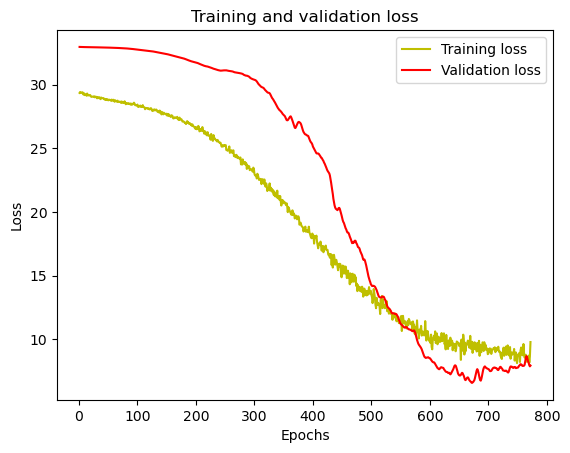

In [485]:
from matplotlib import pyplot as plt
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [486]:
from sklearn import metrics

nn_pred = model.predict(ss.transform(X_test))


nn_MSE = metrics.mean_squared_error(y_test, nn_pred)
nn_MAE = metrics.mean_absolute_error(y_test, nn_pred)
nn_MAPE = metrics.mean_absolute_percentage_error(y_test, nn_pred)
nn_accuracy = 100-(nn_MAPE*100)

print('MSE', nn_MSE )
print('MAE', nn_MAE)
print('MAPE', nn_MAPE)
print('Accuracy', nn_accuracy)

c:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


4/4 [==============================] - 0s 5ms/step
MSE 1722.7616990908723
MAE 22.477485116604154
MAPE 3715362780202265.0
Accuracy -3.7153627802022637e+17


In [479]:
nn_pred = model.predict(ss.transform([[8, 77, 3.64]]))
nn_pred

1/1 [==============================] - 0s 26ms/step


c:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[74.31964]], dtype=float32)

# Actual dataset

In [452]:
import pandas as pd
import json
import numpy as np

import joblib

pd.set_option('display.max_colwidth',  None)

with open('result.json') as f:
    data = json.load(f)

df = pd.DataFrame(data)

df.fillna(0, inplace=True)
df = df.apply(lambda series: pd.to_numeric(series, errors='coerce'))
df = df.dropna()
df.head()

,Epidian 6D,Araldite GY260,Araldite GY250CH,CHS-520 (*CHS-530),CHS-525,CHS-590,Epidian 5,Epidian 6,Epilox AF 18-50,AH-24/Grilonit epoxide 8,...,trisDMP,DCH-99,MXDA,Ethacure 100,nonilfenol,etanol,AHEW,Fazékidő (min),Szakítószilárdság [MPa],Szakadási nyúlás [%]
0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,24.400000,46.0,82.57,5.58
1,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,27.685325,53.0,41.72,3.35
2,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,31.228669,34.0,56.60,4.76
3,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,35.812133,28.0,61.23,5.59
4,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,27.685325,61.0,41.13,3.67


In [453]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.iloc[:, -3:]
y = df.iloc[:, 13]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ss = StandardScaler().fit(X_train)

X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

In [454]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

model = keras.Sequential([
    keras.layers.Dense(X_train.shape[1], activation='relu'),
    keras.layers.Dense(X_train.shape[1]*2, activation='relu'),
    keras.layers.Dense(X_train.shape[1]*4, activation='relu'),
    # keras.layers.Dropout(0.1),
    keras.layers.Dense(X_train.shape[1]*8, activation='relu'),
    # keras.layers.Dropout(0.1),
    keras.layers.Dense(X_train.shape[1]*4, activation='relu'),
    # keras.layers.Dropout(0.1),
    keras.layers.Dense(1, activation='linear') 
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='mean_absolute_error',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)


history = model.fit(X_train, y_train, validation_split=0.2, epochs=1500, batch_size=450, callbacks=[early_stopping])

Epoch 1/1500
1/1 [==============================] - 1s 1s/step - loss: 41.7418 - accuracy: 0.4783 - val_loss: 37.5357 - val_accuracy: 0.5172
Epoch 2/1500
1/1 [==============================] - 0s 60ms/step - loss: 41.7361 - accuracy: 0.4783 - val_loss: 37.5310 - val_accuracy: 0.5172
Epoch 3/1500
1/1 [==============================] - 0s 60ms/step - loss: 41.7303 - accuracy: 0.4783 - val_loss: 37.5262 - val_accuracy: 0.5172
Epoch 4/1500
1/1 [==============================] - 0s 61ms/step - loss: 41.7245 - accuracy: 0.4783 - val_loss: 37.5216 - val_accuracy: 0.5172
Epoch 5/1500
1/1 [==============================] - 0s 62ms/step - loss: 41.7188 - accuracy: 0.4783 - val_loss: 37.5172 - val_accuracy: 0.5172
Epoch 6/1500
1/1 [==============================] - 0s 59ms/step - loss: 41.7133 - accuracy: 0.4783 - val_loss: 37.5135 - val_accuracy: 0.5172
Epoch 7/1500
1/1 [==============================] - 0s 61ms/step - loss: 41.7082 - accuracy: 0.4783 - val_loss: 37.5105 - val_accuracy: 0.5172
E

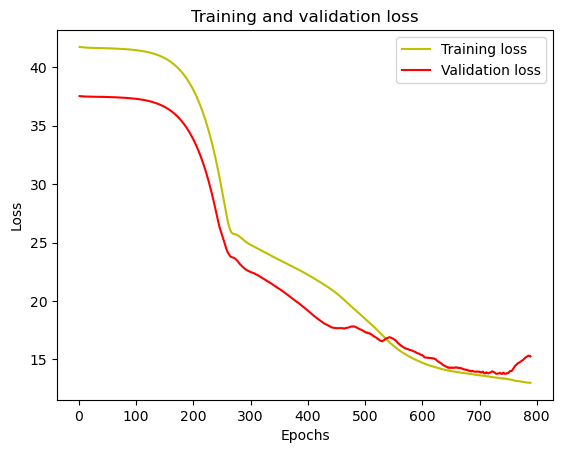

In [455]:
from matplotlib import pyplot as plt
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [456]:
from sklearn import metrics

nn_pred = model.predict(ss.transform(X_test))


nn_MSE = metrics.mean_squared_error(y_test, nn_pred)
nn_MAE = metrics.mean_absolute_error(y_test, nn_pred)
nn_MAPE = metrics.mean_absolute_percentage_error(y_test, nn_pred)
nn_accuracy = 100-(nn_MAPE*100)

print('MSE', nn_MSE )
print('MAE', nn_MAE)
print('MAPE', nn_MAPE)
print('Accuracy', nn_accuracy)

c:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


3/3 [==============================] - 0s 4ms/step
MSE 2794.110374808503
MAE 35.45513640487031
MAPE 1799355119787695.8
Accuracy -1.7993551197876947e+17


In [464]:
nn_pred = model.predict(ss.transform([[8, 77, 3.64]]))
nn_pred

1/1 [==============================] - 0s 25ms/step


c:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[91.399734]], dtype=float32)